In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Tester
mu = np.linspace(18, 22 , 101)
sigma = np.linspace(1, 3, 101)
obs = np.array([
    18.5689, 17.6797, 21.338, 20.9154, 23.5924, 22.297, 22.3189, 22.7245,
    19.6794, 17.9488, 16.3353, 20.4523, 18.6724, 17.613, 17.2653, 23.5638,
    21.2559, 19.7516, 19.006, 19.7858, 18.5335, 20.3822, 19.5539, 24.3929,
    18.8723, 19.6165, 18.8271, 20.4691, 19.847, 18.9893, 20.3704, 20.1216,
    20.4444, 18.1721, 19.1999, 20.8553, 18.603, 18.776, 20.8716, 23.3906,
    20.3816, 15.4786, 21.0475, 20.4619, 18.0967, 20.2748, 21.5501, 20.6133,
    19.0979, 23.1837,
])

vx, vy, vz = np.meshgrid(sigma, mu, obs)

density = norm(vy, vx).pdf(obs)

# print([round(k, 6) for k in likes.ravel()])
likes = density.prod(axis=2)
posterior = likes / likes.sum()
posterior.sum(axis=1)[:10]  # mu


array([2.52477161e-10, 4.42917908e-10, 7.73972632e-10, 1.34738209e-09,
       2.33707555e-09, 4.03939699e-09, 6.95755420e-09, 1.19430560e-08,
       2.04316013e-08, 3.48347071e-08])

In [4]:
posterior.sum(axis=0)[:5]  # sigma

array([5.79583852e-16, 6.59383127e-15, 6.29402596e-14, 5.11077763e-13,
       3.57478935e-12])

In [3]:
mu = np.array([1, 2, 3])
sigma = np.array([4, 5, 6])
obs = np.array([1, 2])

vx, vy, vz = np.meshgrid(sigma, mu, obs)

density = norm(vy, vx).pdf(obs)
density.ravel()
density.prod(axis=2).ravel()

1.4379429389007194

# Basic Numpy

In [3]:
mu, sigma = 20, 2  # the values we want to infer
np.random.seed(42)
observations = np.random.normal(mu, sigma, 50).astype(np.float32)
observations[:10]

array([20.99343 , 19.72347 , 21.295378, 23.04606 , 19.531693, 19.531727,
       23.158426, 21.53487 , 19.06105 , 21.08512 ], dtype=float32)

In [5]:
# build the grid
def numpy_grid(grid_size):
    mu_range = np.linspace(18, 22, grid_size, dtype=np.float32)
    sigma_range = np.linspace(1, 3, grid_size, dtype=np.float32)
    mu_grid, sigma_grid, observations_grid = np.meshgrid(
        mu_range, sigma_range, observations
    )

    # build the prior
    prior = np.ones((grid_size, grid_size))

    # compute the likelihood
    density = norm(mu_grid, sigma_grid).pdf(observations_grid)

    likes = density.prod(axis=2)
    # Alternatively we could use the log-likelihood, but it will spoil the
    # marginals np.log(density).sum(axis=2)

    posterior = likes * prior
    posterior /= posterior.sum()

    # Return the expectations
    print(
        np.sum(mu_range * posterior.sum(axis=1)),
        np.sum(sigma_range * posterior.sum(axis=0))
    )
    return posterior, mu_range, sigma_range

posterior, mu_range, sigma_range = numpy_grid(101)

20.017911902947837 1.854503602880979


## Visualization

Text(1306.8398692810458, 0.5, '$p(\\sigma|data)$')

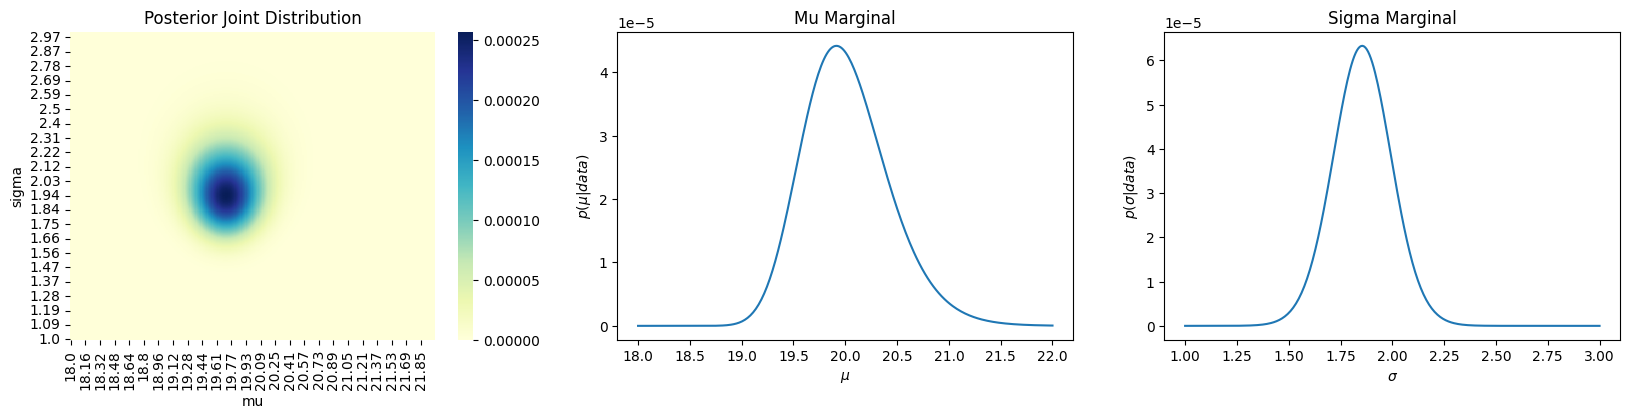

In [6]:
# Visualize
df = pd.DataFrame(posterior, index=sigma_range.round(2), columns=mu_range.round(2))
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax1 = sns.heatmap(df, cmap="YlGnBu", ax=ax[0])
ax1.invert_yaxis()
ax1.set_title("Posterior Joint Distribution")
ax1.set_xlabel("mu")
ax1.set_ylabel("sigma")

ax[1].plot(mu_range, posterior.mean(axis=1))
ax[1].set_title("Mu Marginal")
ax[1].set_xlabel("$\mu$")
ax[1].set_ylabel("$p(\mu|data)$")

ax[2].plot(sigma_range, posterior.mean(axis=0))
ax[2].set_title("Sigma Marginal")
ax[2].set_xlabel("$\sigma$")
ax[2].set_ylabel("$p(\sigma|data)$")

## Benchmark

In [7]:
# observations = np.random.normal(mu, sigma, 50)
%timeit numpy_grid(300)


20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
20.017911902947837 1.854503602880979
217 ms ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# CuPY Implementation

In [8]:
import cupy as cp

def cp_normal(mu_grid, sigma_grid, observations_grid):
    den = cp.sqrt(2 * cp.pi) * sigma_grid
    return cp.exp(-0.5 * ((observations_grid - mu_grid) / sigma_grid) ** 2) / den

observations = cp.asarray(observations, dtype=cp.float32)

def cupy_grid(gridsize):
    mu_range = cp.linspace(18, 22, gridsize, dtype=cp.float32)
    sigma_range = cp.linspace(1, 3, gridsize, dtype=cp.float32)
    mu_grid, sigma_grid, observations_grid = cp.meshgrid(mu_range, sigma_range, observations)

    # build the prior
    prior = cp.ones((gridsize, gridsize))

    # compute the likelihood. In this case we can't use the scipy norm as it only works with
    # numpy arrays, so we will need to craft our own.
    density = cp_normal(mu_grid, sigma_grid, observations_grid)

    likes = density.prod(axis=2)

    posterior = likes * prior
    posterior /= posterior.sum()

    # Return the expectations
    print(
        cp.sum(mu_range * posterior.sum(axis=1)),
        cp.sum(sigma_range * posterior.sum(axis=0))
    )
    return posterior, mu_range, sigma_range

_ = cupy_grid(300)

20.017911905804542 1.8545036075128578


## Benchmark

In [9]:
observations = cp.asarray(observations)
from cupyx.profiler import benchmark
benchmark(cupy_grid, (300, ), n_repeat=20)

20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905804542 1.8545036075128578
20.017911905

cupy_grid           :    CPU:  8981.025 us   +/- 1434.460 (min:  7090.602 / max: 11717.778) us     GPU-0:  9000.526 us   +/- 1441.223 (min:  7103.808 / max: 11730.656) us

# Numba CUDA Implementation

In [10]:
from numba import cuda